# Customer Analysis with Unsupervised Learning

The goal here is to determine customer segments with the goal of determining who should be targeted with advertisements. Although I can't find explicit mention of this, I'm assuming this data is from a wine store since amount of money spent on wine is highly correlated with total money spent. 

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn import metrics
import warnings
import sys
import os
import matplotlib.gridspec as gridspec

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
    
np.random.seed(73)

## Data Processing

In [22]:
DATA_PATH = os.path.join('C:\\', '_local', 'data_sets', 'business', 'marketing_campaign.csv')

df = pd.read_csv(
    DATA_PATH, sep='\t', parse_dates=['Dt_Customer'], infer_datetime_format=True
)

In [3]:
print(f'data shape: {df.shape}')
df.head()

data shape: (2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0000,0,0,2012-04-09,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0000,1,1,2014-08-03,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0000,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0000,1,0,2014-10-02,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0000,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [23]:
# Get age of customer the last time they came to the store
df['Customer_Age'] = df['Dt_Customer'].dt.year - df['Year_Birth']
df = df[df['Customer_Age'] <= 100] # Apparently there were some 120 year olds going to buy wine

In [24]:
# Get household size data

# Number of people in household implied by marital status
marital_household_size_dict = {
    'Single': 1, 'Divorced': 1, 'Widow': 1, 'Alone': 1,
    'Absurd': 1, 'YOLO': 1, 'Together': 2, 'Married': 2
}

# Get whether customer is single
df['Single'] = (df['Marital_Status']
                .isin(['Single', 'Divorced', 'Widow', 'Alone', 'Absurd', 'YOLO'])
                .astype(int)
                .map(lambda x: (x-.5)/2)
               )

# Number of children in each customer's household
df['Num_Children'] = df['Kidhome'] + df['Teenhome']
df['Lives_With_Child'] = (df['Num_Children'] > 0).astype(int).map(lambda x: (x-.5)/2)

In [25]:
# Map education to integers
df['Education'] = df['Education'].replace({
    'Basic': 1, '2n Cycle': 1, 
    'Graduation': 2, 'Master': 2, 'PhD': 3
})

# Map education (ordinal, discrete) to numeric variable
df['Education'] = df['Education'].map(lambda x: (x-.5)/3)

In [26]:
# Total number of store purchases
num_purchases_strings = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Total_Purchases'] = df[num_purchases_strings].sum(axis=1)

# Total amount of money spent in store
category_spending_strings = ['MntWines', 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Spendage'] = df[category_spending_strings].sum(axis=1)

# Total number of campaigns accepted
cmp_accepted_strings = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['TotalCmpAccepted'] = df[cmp_accepted_strings].sum(axis=1)

# Map remaining discrete variables to numerics
df['Complain'] = df['Complain'].map(lambda x: (x-.5)/2)
df['Response'] = df['Response'].map(lambda x: (x-.5)/2)

In [27]:
# We find that only income is missing observations (24)
# df.isnull().sum()[df.isnull().sum() > 0]

df = df.dropna() # Since there are only 24 people with missing incomes, we will drop them from the dataset
df['Income'] = df['Income'].where(df['Income'] < 200000, 200000) # Putting the one guy w/ 600k/year in check

In [28]:
df = df.drop(
    ['Marital_Status', 'Dt_Customer', 'Year_Birth', 'ID', 'Kidhome', 'Teenhome',
     'Z_CostContact', 'Z_Revenue', *cmp_accepted_strings, 'Response'
    ], axis=1
)

df_mean, df_std = df.mean(), df.std()

In [29]:
df.describe().loc[['mean', 'std', 'min', 'max']]

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Customer_Age,Single,Num_Children,Lives_With_Child,Total_Purchases,Total_Spendage,TotalCmpAccepted
mean,0.5343,52025.7067,49.0077,305.1536,26.3240,166.9625,37.6353,27.0348,43.9114,2.3254,4.0877,2.6715,5.8052,5.3217,-0.2455,44.1107,-0.0729,0.9476,0.1072,12.5644,440.0592,0.2982
std,0.1887,21751.2670,28.9419,337.3055,39.7359,224.2262,54.7633,41.0854,51.6997,1.9244,2.7417,2.9271,3.2508,2.4251,0.0473,11.7367,0.2392,0.7493,0.2259,7.2048,429.8913,0.6794
min,0.1667,1730.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.2500,16.0000,-0.2500,0.0000,-0.2500,0.0000,4.0000,0.0000
max,0.8333,200000.0000,99.0000,1493.0000,199.0000,1725.0000,259.0000,262.0000,321.0000,15.0000,27.0000,28.0000,13.0000,20.0000,0.2500,73.0000,0.2500,3.0000,0.2500,32.0000,1798.0000,4.0000


## Data Inspection

In [30]:
df.describe().loc[['std', 'min', 'max']]

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Customer_Age,Single,Num_Children,Lives_With_Child,Total_Purchases,Total_Spendage,TotalCmpAccepted
std,0.1887,21751.2670,28.9419,337.3055,39.7359,224.2262,54.7633,41.0854,51.6997,1.9244,2.7417,2.9271,3.2508,2.4251,0.0473,11.7367,0.2392,0.7493,0.2259,7.2048,429.8913,0.6794
min,0.1667,1730.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.2500,16.0000,-0.2500,0.0000,-0.2500,0.0000,4.0000,0.0000
max,0.8333,200000.0000,99.0000,1493.0000,199.0000,1725.0000,259.0000,262.0000,321.0000,15.0000,27.0000,28.0000,13.0000,20.0000,0.2500,73.0000,0.2500,3.0000,0.2500,32.0000,1798.0000,4.0000


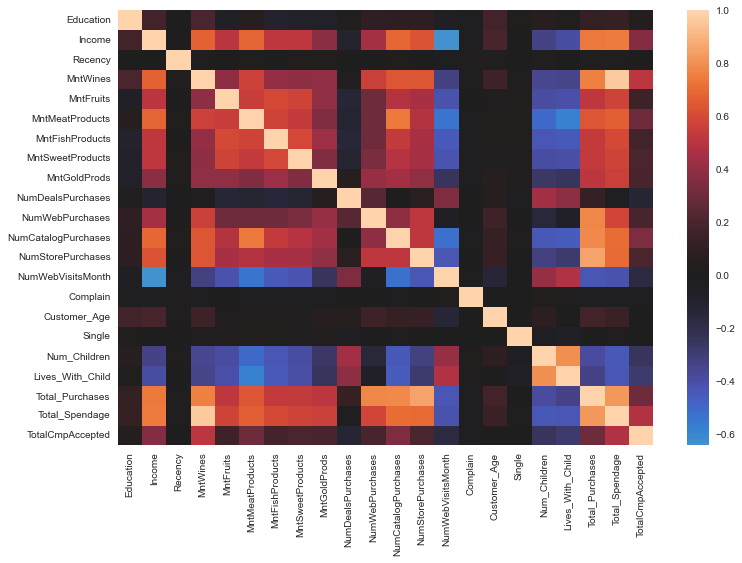

In [31]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), center=0, xticklabels=True, yticklabels=True);

Upon inspection of the data's linear correlation matrix, we find the following among other things:
1. Spending between categories - e.g. fish and meat products - is highly correlated
2. Income is inversely correlated with number of web visits and number of kids
3. Income is correlated with spending in each product category except gold, and thus total spending
4. Amount spent on wine is highly correlated with total amount spent at store (this dataset may be for a wine store)
5. Money spent on wine and in total are correlated with the number of campaigns accepted
6. Recency, education, whether the customer complained, and last visit are not correlated with any other variables.
7. Number of web visits is inversely correlated with spending in each category and in total

## K-Means Clustering

We first examine use of k-means clustering. Given the radically different scales of variables in the data, we need to specify the dissimilarity measure of clustering, otherwise variables with larger variances will be dominant factors in determining which cluster a customer is assigned to.

KMeans clustering in invariant under translation (e.g., shifting each variable to mean 0), so centering each variable around 0 won't change the cluster assignment of a customer. On the other hand, a variable's relative importance in cluster assignment is proportional to its sample variance. Since variables such as income and spending have much larger standard deviations, if we don't scale them, then clusters will basically be entirely determined by those variables.

In every use case, the relative importance of variables should be determined by a combination of domain knowledge and considerations of what the analysis intends to examine. For instance, if the analysis is looking for which customers to send notifications of new wine products to, that analysis would probably benefit from a higher weighting of a customer's total wine spending and purchasing frequency.

In this notebook, I am looking to segment customers based on who should be targeted for advertisements with the goal of generating more revenue. I decided to have (disposable) income and previous spending as the primary factors in clustering. I also operate under the assumption that this data comes from a store which primarily sells wine. The standard deviations / relative importances of each variable are explicitly defined as *desired_sigmas*.

In [32]:
desired_sigmas = [.25, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1.5, 2, 2, 3.5, 2]

def transform(data):
    assert isinstance(data, pd.core.frame.DataFrame)
    global df_mean, df_std, desired_sigmas
    
    d = (data - df_mean) / df_std
    return d * desired_sigmas

def inverse_transform(data):
    assert isinstance(data, pd.core.frame.DataFrame)
    global df_mean, df_std, desired_sigmas
    
    d = data / desired_sigmas
    return d * df_std + df_mean

X = transform(df) # Transform ith variable ~ N(0, desired_sigmas[i])

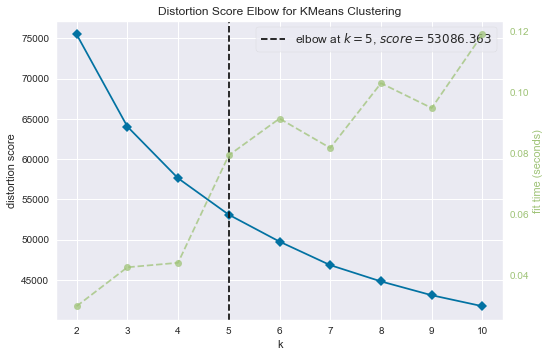

In [33]:
# Fit kmeans on data

KElbowVisualizer(KMeans(), k=10).fit(X).show();

We observe that the elbow is located at k = 5, indicating 5 clusters is our best guess (based on the data) for the number of different clusters. 

We can also fit KMeans on principal components (PCA) and see if this yields a different elbow value for k. Since the components of PCA explain a decreasing amount of the raw data's variance (but sum to the raw data's variance), and KMeans minimizes the within-cluster variance for a given k, the distortion scores for each k are generally increasing with respect to the number of PCs that KMeans is fit on and converge to the distortion scores for that value of k in the raw data.

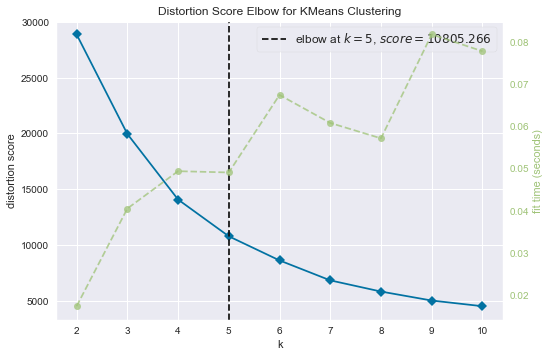

In [34]:
PCA_N_COMPONENTS = 2
pca = PCA(n_components=PCA_N_COMPONENTS).fit(X)
pca_df = pd.DataFrame(pca.transform(X), columns=[f'pc_{p}' for p in range(1, PCA_N_COMPONENTS+1)])

KElbowVisualizer(KMeans(), k=10).fit(pca_df).show();

We see that even fitting the data on only 2 PCs also yields an elbow of k = 4 (fitting with 1 and between 3 and 10 PCs all yields the same elbow).

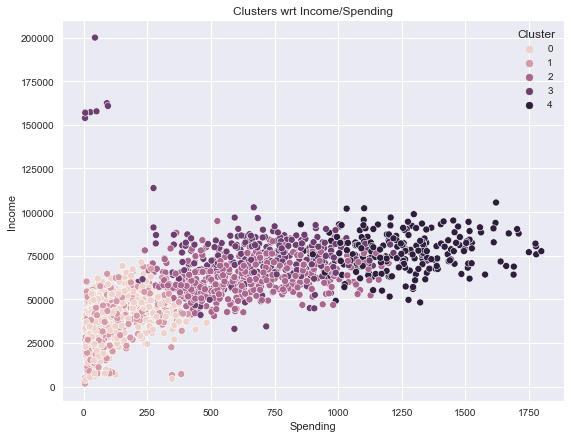

In [35]:
kmeans = KMeans(n_clusters=5).fit(X)
kmeans_preds = kmeans.predict(X)

# Sort cluster indices by center's income
clusters_income_argsort = np.argsort([cc[1] for cc in kmeans.cluster_centers_])
df['KMeans_Preds'] = kmeans_preds
df['KMeans_Preds'] = df['KMeans_Preds'].replace({cluster: arg for arg, cluster in enumerate(clusters_income_argsort)})

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(data=df, x='Total_Spendage', y='Income', hue='KMeans_Preds', ax=ax)
ax.set_title(f'Clusters wrt Income/Spending')
ax.set_ylabel('Income')
ax.set_xlabel('Spending')
ax.legend(title='Cluster')
plt.show()

In the above graph, we can consider cluster 4 as our loyal customers: these people spend the most money at our store and have the most disposable income. Since cluster 4 customers already spend a lot at our store, targeting them with advertisements may not change how much they spend here. Clusters 2 and 3 are high priority customers: these people spend less than cluster 4 but have either about the same income, or have large income but do not frequent our store (perhaps targeting them with advertisements would make them come here more frequently). Clusters 0 and 1 are low priority since they do not spend much and have lower income / spending potential.

There is some (apparent) noise in the cluster assignemt which is due to other variables. For instance, even if someone has high income and spending, if they did not respond positively to other ad campaigns (TotalCmpAccepted), then targeting them with high priority may not be productive. 

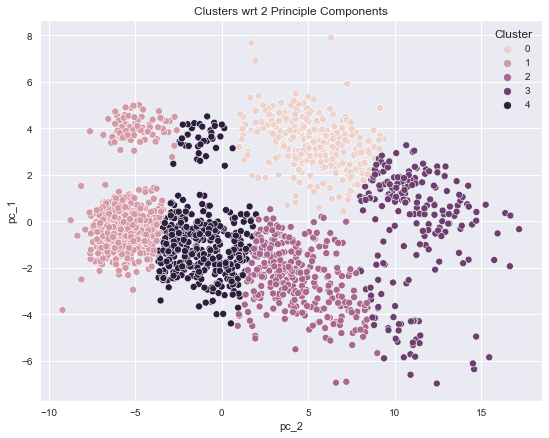

In [36]:
kmeans_pca = KMeans(n_clusters=5).fit(pca_df)
kmeans_pca_preds = kmeans_pca.predict(pca_df)

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(data=pca_df, x='pc_1', y='pc_2', hue=kmeans_pca_preds, ax=ax)
ax.set_title(f'Clusters wrt 2 Principle Components')
ax.set_ylabel('pc_1')
ax.set_xlabel('pc_2')
ax.legend(title='Cluster')
plt.show()

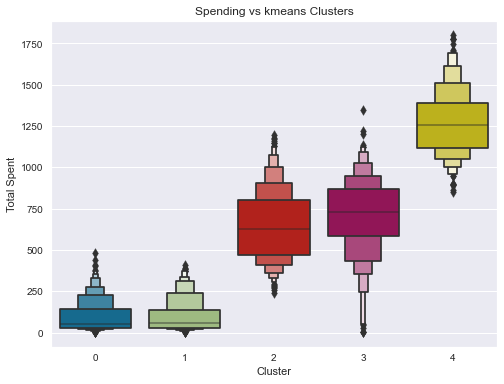

In [37]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxenplot(data=df, x='KMeans_Preds', y='Total_Spendage', ax=ax)
ax.set_xlabel('Cluster')
ax.set_ylabel('Total Spent')
ax.set_title(f'Spending vs kmeans Clusters')
plt.show()

In [20]:
class SeabornFig2Grid():
    
    # Thanks to ImportanceOfBeingErnest on StackOverflow

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

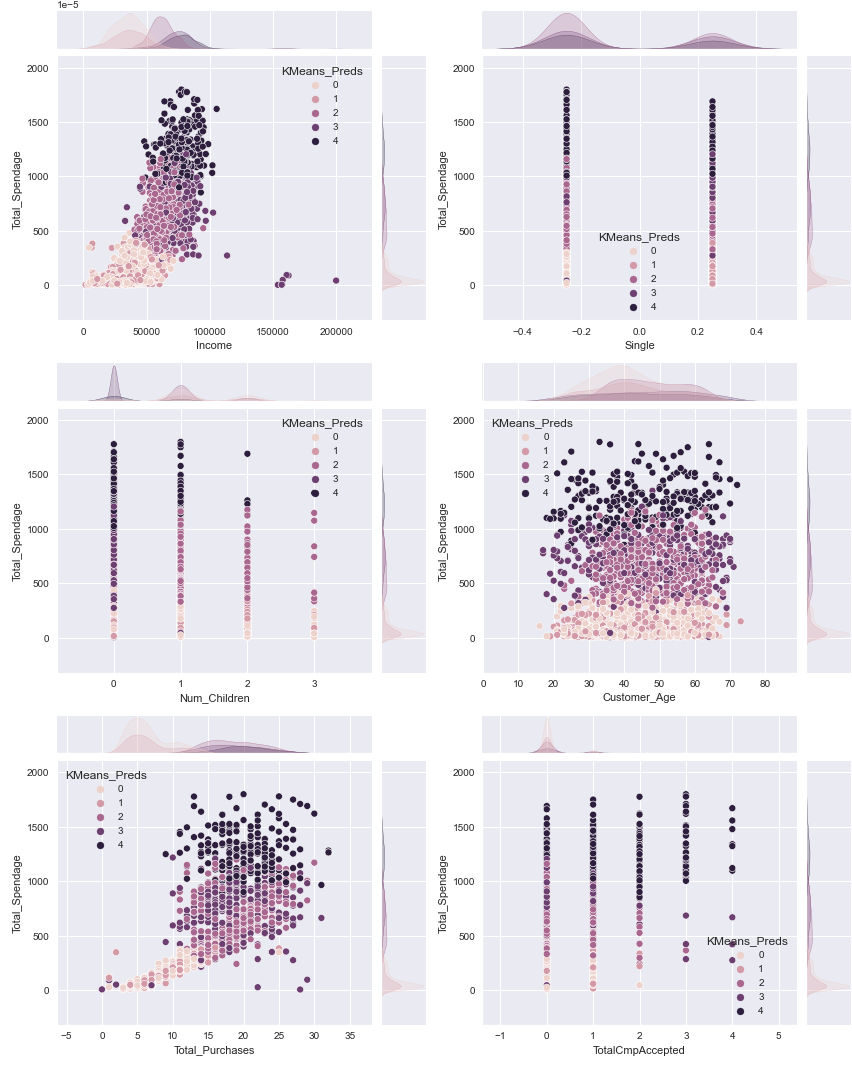

In [38]:
profiling_variables = ['Income', 'Single', 'Num_Children', 'Customer_Age', 'Total_Purchases', 'TotalCmpAccepted']

sns.set_style('darkgrid')
fig = plt.figure(figsize=(12, 15))
gs = gridspec.GridSpec(3, 2)

for g, var in enumerate(profiling_variables):  
    p = sns.jointplot(data=df, x=var, y='Total_Spendage', hue='KMeans_Preds', kind='scatter')
    SeabornFig2Grid(p, fig, gs[g])

gs.tight_layout(fig)
plt.show()

From the above plots, we can make the following conclusions about our clusters.

0. Customers in cluster 0 have the lowest income, make small and infrequent purchases, may be single or married, usually live with at less than 2 children, and are the least likely to respond well to previous ad campaigns.

1. Customers in cluster 1 have income slightly greater than cluster 0, don't spend much but occasionally buy more frequently, are usually married with 1 child, are about the same age on average as cluster 0, and respond better to ads than cluster 0.

We can draw conclusions about the other clusters in a similar manner.